In [171]:
import torch
import torch.nn as nn
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from sklearn.model_selection import train_test_split

In [155]:
df = pd.read_csv(r"/content/fashion-mnist_train.csv")
df.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6,0,0,0,0,0,0,0,5,0,...,0,0,0,30,43,0,0,0,0,0
3,0,0,0,0,1,2,0,0,0,0,...,3,0,0,0,0,1,0,0,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [156]:
X_train = df.drop(columns=['label'],axis=1)
Y_train = df[['label']]

x_train, X_val, y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.2, random_state=42)

x_train = torch.tensor(x_train.values, dtype=torch.float32)
y_train = torch.tensor(y_train.values.squeeze(), dtype=torch.long)

X_val = torch.tensor(X_val.values, dtype=torch.float32)
Y_val = torch.tensor(Y_val.values.squeeze(), dtype=torch.long)

loss_fn = torch.nn.CrossEntropyLoss()

In [157]:
def train_one_epoch(model , optimizer , X, Y,Bs=100):
    indexes = np.random.permutation(len(X))
    losses=[]
    for i,batch_start in enumerate(range(0,len(X),Bs)):
        optimizer.zero_grad()

        x = X[batch_start:min(batch_start + Bs, len(X))]
        y = Y[batch_start:min(batch_start + Bs, len(Y))]

        #print("x = ",torch.isnan(x).sum().item(),"len= ",len(x))
        #print("y = ",y)
        y_pred = model(x)
        #print("y_pred = ",torch.isnan(y_pred).sum().item())
        loss = loss_fn(y_pred,y)
        loss.backward()
        #torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        #print("loss = ",loss)

        losses.append(loss.item())

    return losses

In [158]:
def compute_validation_loss(model, X_val, Y_val, batch_size=100):
    model.eval()  # Set model to evaluation mode (disables dropout, batchnorm updates)
    val_losses = []

    with torch.no_grad():  # Disable gradient computation for validation
        for batch_start in range(0, len(X_val), batch_size):
            x = X_val[batch_start:min(batch_start + batch_size, len(X_val))]
            y = Y_val[batch_start:min(batch_start + batch_size, len(Y_val))]

            y_pred = model(x)
            loss = loss_fn(y_pred, y)
            val_losses.append(loss.item())

    model.train()  # Set back to training mode
    return np.mean(val_losses)

In [196]:
def train(model, optimizer, X_train, Y_train,X_val, Y_val, Bs=100,num_epochs=100, min_delta = 0.001, patience = 5):

    epoch_losses = []
    val_losses = []
    best_loss = float("inf")
    epochs_no_improve = 0

    pbar = tqdm(range(num_epochs))

    for ep in pbar:
        batch_losses = train_one_epoch(model, optimizer,X_train, Y_train, Bs)
        avg_loss = np.mean(batch_losses)
        epoch_losses.append(avg_loss)

        val_loss = compute_validation_loss(model, X_val, Y_val)
        val_losses.append(val_loss)

        pbar.set_description(f"Epoch {ep+1}: Train Loss = {avg_loss:.4f}, Val Loss = {val_loss:.4f}")

        if abs(avg_loss-best_loss) > min_delta :
            best_loss = avg_loss
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1

        if epochs_no_improve >= patience or ((val_losses[-1] > best_loss)):
            print(f"\nEarly stopping at epoch {ep+1}. No improvement for {patience} epochs.")
            break
    return epoch_losses,val_losses


In [160]:
def print_train_valid_plot(epoch_losses,val_losses):
    plt.plot(epoch_losses, label="Training Loss", color='blue')
    plt.plot(val_losses, label="Validation Loss", color='red', linestyle='dashed')

    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Training vs Validation Loss Curve")
    plt.legend()
    plt.grid(True)
    plt.show()


In [184]:
class Model(nn.Module):
    def __init__(self, input_shape, output_shape, hidden_act='relu', n_layers=3, hidden_dim=120):
        super(Model, self).__init__()

        activation_functions = {
            'relu': nn.ReLU(),
            'sigmoid': nn.Sigmoid(),
            'tanh': nn.Tanh(),
            'leaky_relu': nn.LeakyReLU(),
            'elu': nn.ELU()
        }
        if hidden_act not in activation_functions:
            raise ValueError(f"Unsupported activation function: {hidden_act}")

        self.hidden_act = activation_functions[hidden_act]

        self.layers = nn.ModuleList()

        prev_dim = input_shape

        for _ in range(n_layers):
            self.layers.append(nn.Linear(prev_dim, hidden_dim))
            self.layers.append(self.hidden_act)
            prev_dim = hidden_dim

        self.output_layer = nn.Linear(hidden_dim, output_shape)



    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        x = self.output_layer(x)
        return x

# Model 1

Epoch 3: Train Loss = 0.3812, Val Loss = 0.3860:   2%|▏         | 2/100 [00:05<04:05,  2.51s/it]


Early stopping at epoch 3. No improvement for 5 epochs.


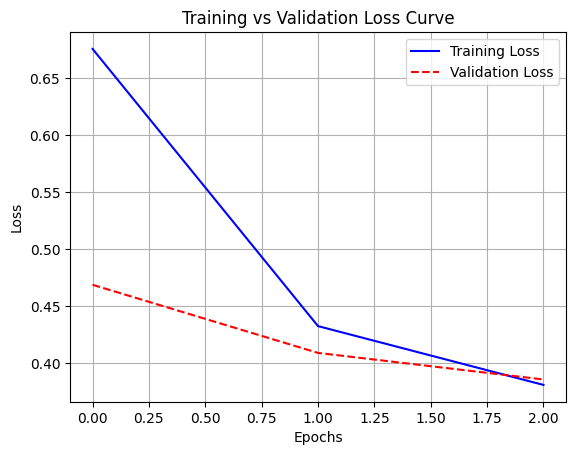

In [197]:
model1 = Model(input_shape=x_train.shape[1], output_shape=len(y_train.unique()) , hidden_act='relu', n_layers=3, hidden_dim=120)
optimizer1 = torch.optim.Adam(model1.parameters() , lr=1e-4)
epoch_losses1,val_losses1 = train(model1, optimizer1, x_train, y_train, X_val, Y_val, Bs=100,num_epochs=100, min_delta = 0.001, patience = 5)
print_train_valid_plot(epoch_losses1,val_losses1)

# Model 2

## 1-increasing number of hidden layers and number of neurons
## 2-decreasing number of batch size
## 3-increasing fitting by decreasing error tolerance(min_delta)

Epoch 4: Train Loss = 0.3101, Val Loss = 0.3334:   3%|▎         | 3/100 [00:37<20:06, 12.43s/it]


Early stopping at epoch 4. No improvement for 5 epochs.


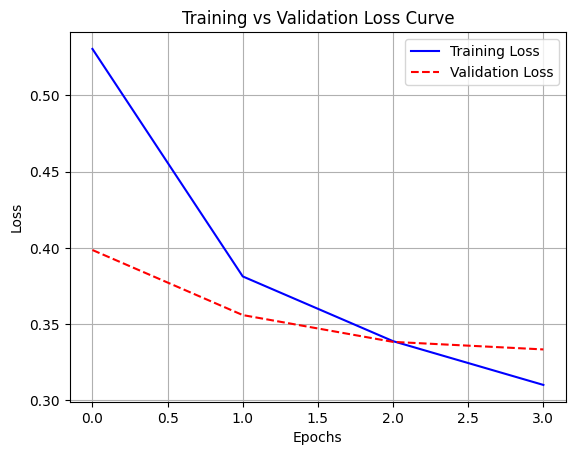

In [201]:
model2 = Model(input_shape=x_train.shape[1], output_shape=len(y_train.unique()) , hidden_act='relu', n_layers=6, hidden_dim=240)
optimizer2 = torch.optim.Adam(model2.parameters() , lr=1e-4)
epoch_losses2,val_losses2 = train(model2, optimizer2, x_train, y_train, X_val, Y_val, Bs=32,num_epochs=100, min_delta = 0.0001, patience = 5)
print_train_valid_plot(epoch_losses2,val_losses2)

# Model 3

## I will change act. fun. to sigmoid and optimizer to adamw

Epoch 11: Train Loss = 0.5271, Val Loss = 0.5305:  10%|█         | 10/100 [00:26<03:57,  2.64s/it]



Early stopping at epoch 11. No improvement for 5 epochs.


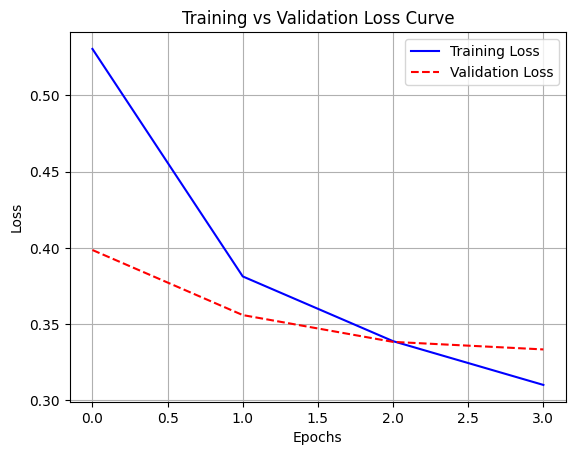

In [202]:
model3 = Model(input_shape=x_train.shape[1], output_shape=len(y_train.unique()) , hidden_act='sigmoid', n_layers=3, hidden_dim=120)
optimizer3 = torch.optim.AdamW(model3.parameters() , lr=1e-4)
epoch_losses3,val_losses3 = train(model3, optimizer3, x_train, y_train, X_val, Y_val, Bs=100,num_epochs=100, min_delta = 0.001, patience = 5)
print_train_valid_plot(epoch_losses2,val_losses2)

# Test Accuracy

In [167]:
label_map = {
    0: "T-shirt/top",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle boot"
}

def print_test_true_Pred(model,X_test,y_test):
    idx = np.random.randint(len(X_test))
    image = X_test[idx].reshape(28, 28)
    label = y_test[idx].item()

    model.eval()
    with torch.no_grad():
        y_pred = model(X_test[idx].unsqueeze(0))
        predicted_label = torch.argmax(y_pred, dim=1).item()


    # Display image
    plt.imshow(image, cmap="gray")
    plt.title(f"True Label: {label_map[label]}, Predicted: {label_map[predicted_label]}")
    plt.axis("off")
    plt.show()

In [168]:
def evaluate_model(model, X_test, y_test):
    model.eval()

    with torch.no_grad():
        y_pred = model(X_test)
        y_pred_labels = torch.argmax(y_pred, dim=1)

    accuracy = (y_pred_labels == y_test).float().mean().item()
    #print(f"Test Accuracy: {accuracy * 100:.2f}%")
    return accuracy


In [169]:
df_test = pd.read_csv(r"/content/fashion-mnist_test.csv")

X_test = df_test.drop(columns=['label'], axis=1)
y_test = df_test['label']

X_test = torch.tensor(X_test.values, dtype=torch.float32)
y_test = torch.tensor(y_test.values.squeeze(), dtype=torch.long)


============== Model 1 ================
model1 accuracy =  0.8650000095367432


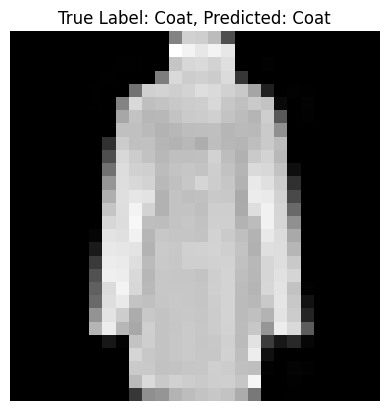

============== Model 2 ================
model2 accuracy =  0.8791999816894531


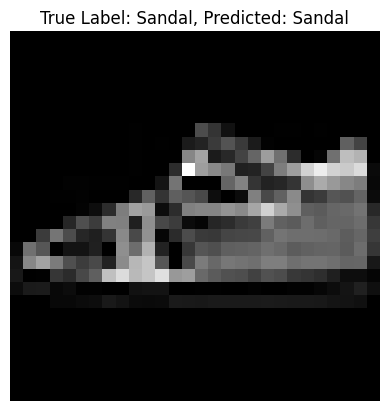

============== Model 3 ================
model3 accuracy =  0.8215000033378601


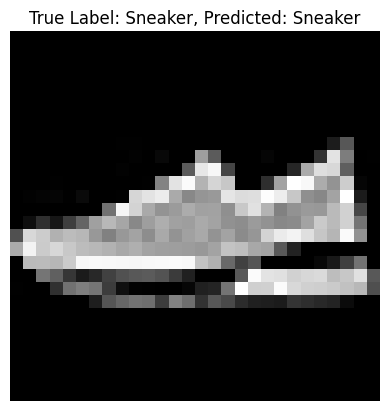

In [203]:
print("============== Model 1 ================")
print("model1 accuracy = ",evaluate_model(model1, X_test, y_test))
print_test_true_Pred(model1,X_test,y_test)

print("============== Model 2 ================")
print("model2 accuracy = ",evaluate_model(model2, X_test, y_test))
print_test_true_Pred(model2,X_test,y_test)

print("============== Model 3 ================")
print("model3 accuracy = ",evaluate_model(model3, X_test, y_test))
print_test_true_Pred(model3,X_test,y_test)

In [210]:
results = pd.DataFrame()

results['Models']= [1,2,3]
results['hidden_act']= ['relu','relu','sigmoid']
results['optimizer']= ['Adam','Adam','AdamW']
results['n_layers']= [3,6,3]
results['hidden_dim']= [120,240,120]
results['Batch Size']= [100,32,100]
results['min_delta']= [0.001,.0001,0.001]
results['patience']= [5,5,5]
results['num_epochs_till_convergence']= [3,4,11]
results['train_loss']= [0.3812,0.3101,0.5271]
results['valid_loss']= [0.3860,0.3334,0.5305]
results['Test Accuracy']= [0.865,0.879,0.821]

results

,Models,hidden_act,optimizer,n_layers,hidden_dim,Batch Size,min_delta,patience,num_epochs_till_convergence,train_loss,valid_loss,Test Accuracy
0,1,relu,Adam,3,120,100,0.0010,5,3,0.3812,0.3860,0.865
1,2,relu,Adam,6,240,32,0.0001,5,4,0.3101,0.3334,0.879
2,3,sigmoid,AdamW,3,120,100,0.0010,5,11,0.5271,0.5305,0.821


# Conclusion

## 1-Increasing model complexity made better performance
## 2-batch size didn't make big difference from 100 to 32
## 3-Adam and AdamW didn't make differences
## 4-relu is better than sigmoid